Explained variance ratio: 0.7462558044981442


c:\Users\boomi\anaconda3\envs\pyai\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


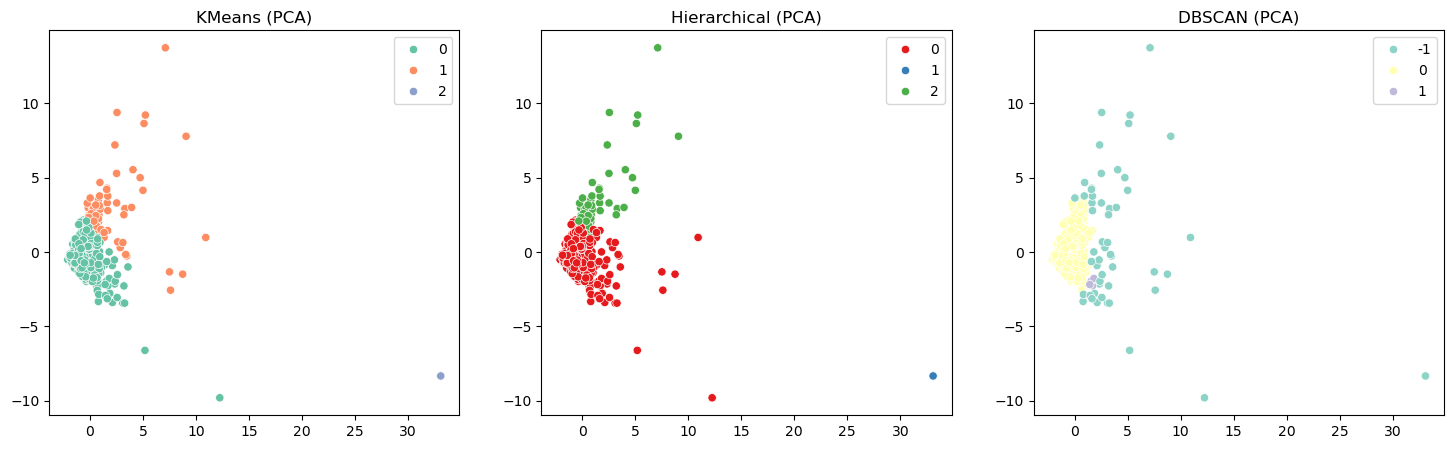

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score

df=pd.read_csv('Wholesale customers data.csv')
features = ["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]
X = df[features]


scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_.sum())

results = []

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X_pca)
sil_kmeans = silhouette_score(X_pca, labels_kmeans)
ari_kmeans = adjusted_rand_score(df["Channel"], labels_kmeans)

results.append({
    "Algorithm": "KMeans (PCA)",
    "Silhouette": round(sil_kmeans, 3),
    "ARI vs Channel": round(ari_kmeans, 3),
    "Clusters": len(set(labels_kmeans)),
    "Outliers": 0,
    "Cluster Sizes": dict(pd.Series(labels_kmeans).value_counts().sort_index())
})

hc = AgglomerativeClustering(n_clusters=3, linkage="ward")
labels_hc = hc.fit_predict(X_pca)
sil_hc = silhouette_score(X_pca, labels_hc)
ari_hc = adjusted_rand_score(df["Channel"], labels_hc)

results.append({
    "Algorithm": "Hierarchical (PCA)",
    "Silhouette": round(sil_hc, 3),
    "ARI vs Channel": round(ari_hc, 3),
    "Clusters": len(set(labels_hc)),
    "Outliers": 0,
    "Cluster Sizes": dict(pd.Series(labels_hc).value_counts().sort_index())
})

db = DBSCAN(eps=0.5, min_samples=5)
labels_db = db.fit_predict(X_pca)

mask = labels_db != -1
X_no_outliers = X_pca[mask]
labels_no_outliers = labels_db[mask]

if len(set(labels_no_outliers)) > 1:
    sil_db = silhouette_score(X_no_outliers, labels_no_outliers)
else:
    sil_db = -1

ari_db = adjusted_rand_score(df["Channel"], labels_db) if len(set(labels_no_outliers)) > 1 else -1

results.append({
    "Algorithm": "DBSCAN (PCA)",
    "Silhouette": round(sil_db, 3),
    "ARI ": round(ari_db, 3),
    "Clusters": len(set(labels_no_outliers)),
    "Outliers": (labels_db == -1).sum(),
    "Cluster Sizes": dict(pd.Series(labels_no_outliers).value_counts().sort_index())
})


results_df = pd.DataFrame(results)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# KMeans
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_kmeans, palette="Set2", ax=axes[0])
axes[0].set_title("KMeans (PCA)")

# Hierarchical
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_hc, palette="Set1", ax=axes[1])
axes[1].set_title("Hierarchical (PCA)")

# DBSCAN
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_db, palette="Set3", ax=axes[2])
axes[2].set_title("DBSCAN (PCA)")

plt.show()


In [3]:
results_df

,Algorithm,Silhouette,ARI vs Channel,Clusters,Outliers,Cluster Sizes
0,KMeans (PCA),0.574,0.282,3,0,"{0: 378, 1: 61, 2: 1}"
1,Hierarchical (PCA),0.556,0.269,3,0,"{0: 389, 1: 1, 2: 50}"
2,DBSCAN (PCA),0.424,0.057,2,53,"{0: 383, 1: 4}"
